# Advanced Classification with Hyperparameter Tuning: A Comprehensive Guide

This notebook provides a practical guide to implementing various classification algorithms and performing hyperparameter tuning using real-world data. We will cover K-Nearest Neighbors, Decision Trees, Random Forest, Voting, Stacking, and AdaBoost, along with methods to find their optimal hyperparameters.

## 1. Setup and Data Loading

We begin by importing necessary libraries and loading a real-world classification dataset from `scikit-learn`. For this example, we'll use the Breast Cancer Wisconsin (Diagnostic) dataset, which is a classic binary classification problem.

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

In [8]:
# Load the dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

print(f"Dataset shape: {X.shape}")
print(f"Target classes: {cancer.target_names}")
print(f"Number of features: {cancer.feature_names.shape[0]}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Dataset shape: (569, 30)
Target classes: ['malignant' 'benign']
Number of features: 30
Training set shape: (398, 30)
Testing set shape: (171, 30)


In [7]:
y.shape

(569,)

## 2. Data Preprocessing: Feature Scaling

Feature scaling is crucial for algorithms that rely on distance metrics (like KNN and SVMs) or gradient descent (like Logistic Regression). Even for tree-based models, while not strictly necessary, it can sometimes aid convergence or consistency in certain implementations. We will use `StandardScaler` to transform our features so they have a mean of 0 and a standard deviation of 1.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully.")

Features scaled successfully.


## 3. Evaluation Helper Function

To streamline our evaluation process, we'll create a helper function that takes true labels and predictions, then prints common classification metrics and a confusion matrix.

In [10]:
def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    print(f"### {model_name} Performance ###")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        # For binary classification, roc_auc_score expects probabilities of the positive class
        print(f"ROC AUC: {roc_auc_score(y_true, y_proba[:, 1] if y_proba.ndim > 1 else y_proba):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=cancer.target_names, yticklabels=cancer.target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    print("\n" + "="*50 + "\n")

## 4. Classification Algorithms and Hyperparameter Tuning

We will now implement each classification algorithm, define a hyperparameter search space, and use `GridSearchCV` or `RandomizedSearchCV` to find the best parameters. We'll then evaluate the best performing model.

### 4.1. K-Nearest Neighbors (KNN)

KNN is a simple, non-parametric, lazy learning algorithm that classifies a new data point based on the majority class of its `n_neighbors` closest points in the training set.

**Key Hyperparameters:**
- `n_neighbors`: Number of neighbors to consider (odd numbers usually preferred to avoid ties).
- `weights`: Weight function used in prediction. 'uniform' (all points equally weighted) or 'distance' (closer points have more weight).
- `p`: Power parameter for the Minkowski metric. `p=1` for Manhattan distance, `p=2` for Euclidean distance.

### KNN Classifier Performance ###
Accuracy: 0.9591
Precision: 0.9386
Recall: 1.0000
F1-Score: 0.9683
ROC AUC: 0.9827

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        64
           1       0.94      1.00      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171


Confusion Matrix:


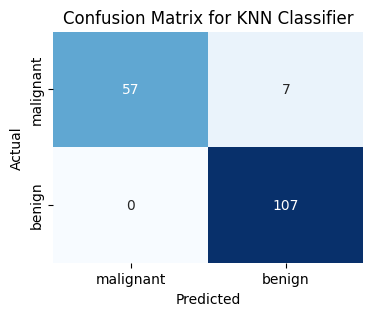

In [11]:
knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)
evaluate_model(y_test, y_pred_knn, y_proba_knn, model_name="KNN Classifier")



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best KNN parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best KNN accuracy: 0.9724
### Optimized K-Nearest Neighbors Performance ###
Accuracy: 0.9591
Precision: 0.9545
Recall: 0.9813
F1-Score: 0.9677
ROC AUC: 0.9795

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        64
           1       0.95      0.98      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171


Confusion Matrix:


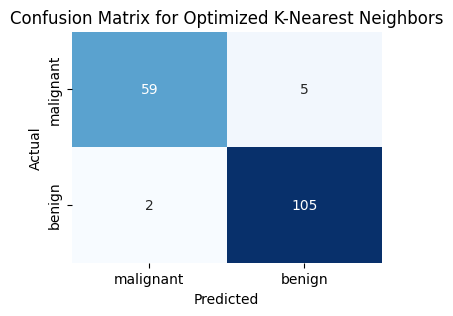

In [5]:
knn = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
knn_grid_search.fit(X_train_scaled, y_train)

print(f"Best KNN parameters: {knn_grid_search.best_params_}")
print(f"Best KNN accuracy: {knn_grid_search.best_score_:.4f}")

best_knn_model = knn_grid_search.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_scaled)
y_proba_knn = best_knn_model.predict_proba(X_test_scaled)

evaluate_model(y_test, y_pred_knn, y_proba_knn, "Optimized K-Nearest Neighbors")

### 4.2. Decision Tree (DT)

Decision Trees create a tree-like model of decisions and their possible consequences. They are intuitive and easily interpretable, but can be prone to overfitting.

**Key Hyperparameters:**
- `criterion`: Function to measure the quality of a split ('gini' for Gini impurity, 'entropy' for information gain).
- `max_depth`: Maximum depth of the tree. Prevents overfitting by limiting tree growth.
- `min_samples_split`: Minimum number of samples required to split an internal node.
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node.
- `max_features`: Number of features to consider when looking for the best split.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 13, 'max_features': 0.8998609717152555, 'min_samples_leaf': 3, 'min_samples_split': 13}
Best Decision Tree accuracy: 0.9424
### Optimized Decision Tree Performance ###
Accuracy: 0.9240
Precision: 0.9273
Recall: 0.9533
F1-Score: 0.9401
ROC AUC: 0.9371

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        64
           1       0.93      0.95      0.94       107

    accuracy                           0.92       171
   macro avg       0.92      0.91      0.92       171
weighted avg       0.92      0.92      0.92       171


Confusion Matrix:


/Users/yenokhakobyan/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yenokhakobyan/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yenokhakobyan/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/yenokhakobyan/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_p

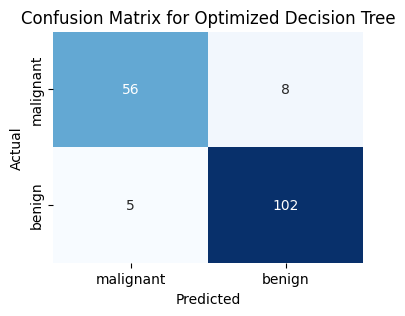

In [6]:
dt = DecisionTreeClassifier(random_state=42)

# Using RandomizedSearchCV for potentially larger search space
dt_param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 15), # Random integer from 3 to 14
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.5, 1.0) # Random float from 0.5 to 1.0
}

dt_random_search = RandomizedSearchCV(dt, dt_param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
dt_random_search.fit(X_train_scaled, y_train)

print(f"Best Decision Tree parameters: {dt_random_search.best_params_}")
print(f"Best Decision Tree accuracy: {dt_random_search.best_score_:.4f}")

best_dt_model = dt_random_search.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)
y_proba_dt = best_dt_model.predict_proba(X_test_scaled)

evaluate_model(y_test, y_pred_dt, y_proba_dt, "Optimized Decision Tree")

### 4.3. Random Forest (RF)

Random Forest is an ensemble method that builds multiple decision trees and merges their predictions. It's a powerful algorithm known for its high accuracy and robustness against overfitting.

**Key Hyperparameters:**
- `n_estimators`: The number of trees in the forest.
- `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`: Similar to Decision Tree, but these apply to individual trees within the forest.
- `bootstrap`: Whether bootstrap samples are used when building trees.

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Random Forest parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest accuracy: 0.9725
### Optimized Random Forest Performance ###
Accuracy: 0.9415
Precision: 0.9450
Recall: 0.9626
F1-Score: 0.9537
ROC AUC: 0.9893

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        64
           1       0.94      0.96      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171


Confusion Matrix:


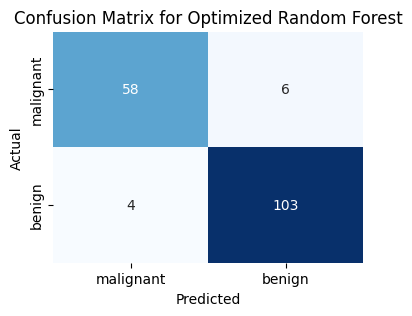

In [7]:
rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8]
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_scaled, y_train)

print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest accuracy: {rf_grid_search.best_score_:.4f}")

best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)
y_proba_rf = best_rf_model.predict_proba(X_test_scaled)

evaluate_model(y_test, y_pred_rf, y_proba_rf, "Optimized Random Forest")

### 4.4. Ensemble Method: Voting Classifier

A `VotingClassifier` combines predictions from multiple diverse base models. For 'hard' voting, it uses majority rule. For 'soft' voting, it averages predicted probabilities.

**Key Hyperparameters:**
- `estimators`: A list of (name, estimator) tuples for the base models.
- `voting`: 'hard' or 'soft'. 'soft' usually performs better if base models are well-calibrated and support `predict_proba`.
- `weights`: Optional list of weights for individual estimators.

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Voting Classifier parameters: {'weights': [1, 1, 1, 1]}
Best Voting Classifier accuracy: 0.9775
### Optimized Voting Classifier Performance ###
Accuracy: 0.9591
Precision: 0.9386
Recall: 1.0000
F1-Score: 0.9683
ROC AUC: 0.9939

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        64
           1       0.94      1.00      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171


Confusion Matrix:


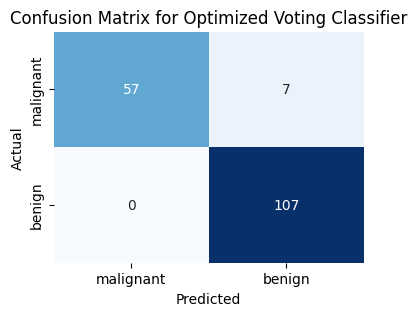

In [8]:
# Using the best estimators found previously or defining new ones
estimator1 = KNeighborsClassifier(n_neighbors=best_knn_model.n_neighbors, weights=best_knn_model.weights, p=best_knn_model.p) # Use optimized KNN
estimator2 = DecisionTreeClassifier(random_state=42, **dt_random_search.best_params_) # Use optimized DT
estimator3 = RandomForestClassifier(random_state=42, **rf_grid_search.best_params_) # Use optimized RF
estimator4 = LogisticRegression(random_state=42, solver='liblinear') # A simple logistic regression

voting_clf = VotingClassifier(estimators=[
    ('knn', estimator1),
    ('dt', estimator2),
    ('rf', estimator3),
    ('lr', estimator4)
], voting='soft', n_jobs=-1) # Use soft voting as models support probabilities

# Hyperparameter tuning for VotingClassifier (optional, can tune individual weights or voting type)
voting_param_grid = {
    'weights': [
        [1, 1, 1, 1],
        [0.5, 1, 1, 0.5],
        [0.2, 0.3, 0.3, 0.2]
    ]
}

voting_grid_search = GridSearchCV(voting_clf, voting_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
voting_grid_search.fit(X_train_scaled, y_train)

print(f"Best Voting Classifier parameters: {voting_grid_search.best_params_}")
print(f"Best Voting Classifier accuracy: {voting_grid_search.best_score_:.4f}")

best_voting_model = voting_grid_search.best_estimator_
y_pred_voting = best_voting_model.predict(X_test_scaled)
y_proba_voting = best_voting_model.predict_proba(X_test_scaled)

evaluate_model(y_test, y_pred_voting, y_proba_voting, "Optimized Voting Classifier")

### 4.5. Ensemble Method: Stacking Classifier

Stacking (or stacked generalization) trains a meta-model to combine the predictions of several base estimators. The base models are trained on the full training data, and the meta-model is trained on the out-of-fold predictions of the base models.

**Key Hyperparameters:**
- `estimators`: A list of (name, estimator) tuples for the base models.
- `final_estimator`: The classifier used to combine the base model predictions.
- `cv`: Number of folds for cross-validation to generate predictions for the final estimator.
- `passthrough`: If `True`, original features are also passed to the `final_estimator`.

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Stacking Classifier parameters: {'final_estimator__C': 0.1, 'passthrough': True}
Best Stacking Classifier accuracy: 0.9799
### Optimized Stacking Classifier Performance ###
Accuracy: 0.9766
Precision: 0.9725
Recall: 0.9907
F1-Score: 0.9815
ROC AUC: 0.9965

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        64
           1       0.97      0.99      0.98       107

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171


Confusion Matrix:


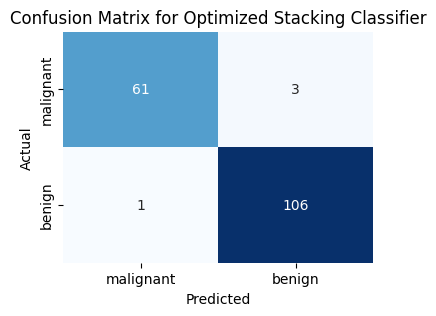

In [9]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=best_knn_model.n_neighbors, weights=best_knn_model.weights, p=best_knn_model.p)),
    ('rf', RandomForestClassifier(random_state=42, **rf_grid_search.best_params_)),
    ('lr', LogisticRegression(random_state=42, solver='liblinear'))
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(solver='liblinear', random_state=42),
    cv=5, # Use 5-fold cross-validation for generating meta-features
    passthrough=False,
    n_jobs=-1
)

# Hyperparameter tuning for Stacking (tuning final_estimator or passthrough)
stacking_param_grid = {
    'final_estimator__C': [0.1, 1.0, 10],
    'passthrough': [True, False]
}

stacking_grid_search = GridSearchCV(stacking_clf, stacking_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
stacking_grid_search.fit(X_train_scaled, y_train)

print(f"Best Stacking Classifier parameters: {stacking_grid_search.best_params_}")
print(f"Best Stacking Classifier accuracy: {stacking_grid_search.best_score_:.4f}")

best_stacking_model = stacking_grid_search.best_estimator_
y_pred_stacking = best_stacking_model.predict(X_test_scaled)
y_proba_stacking = best_stacking_model.predict_proba(X_test_scaled)

evaluate_model(y_test, y_pred_stacking, y_proba_stacking, "Optimized Stacking Classifier")

### 4.6. Ensemble Method: AdaBoost Classifier

AdaBoost (Adaptive Boosting) is a boosting algorithm that trains a sequence of weak learners (typically decision stumps). Each subsequent learner focuses on the misclassified examples of the previous ones, and the final prediction is a weighted sum of the weak learners' predictions.

**Key Hyperparameters:**
- `estimator`: The base estimator (default is a DecisionTreeClassifier with `max_depth=1`).
- `n_estimators`: The maximum number of estimators at which boosting is terminated.
- `learning_rate`: Shrinks the contribution of each estimator. A lower learning rate requires a higher number of estimators.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best AdaBoost Classifier parameters: {'estimator': DecisionTreeClassifier(max_depth=2, random_state=42), 'learning_rate': 1.0, 'n_estimators': 50}
Best AdaBoost Classifier accuracy: 0.9750
### Optimized AdaBoost Classifier Performance ###
Accuracy: 0.9649
Precision: 0.9633
Recall: 0.9813
F1-Score: 0.9722
ROC AUC: 0.9928

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        64
           1       0.96      0.98      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171


Confusion Matrix:


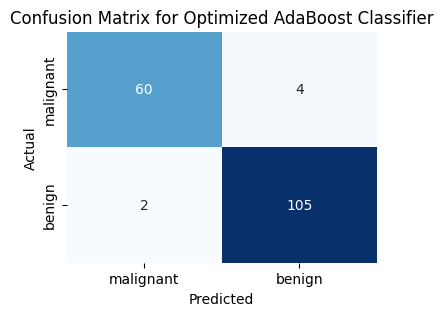

In [10]:
ada = AdaBoostClassifier(random_state=42)

ada_param_grid = {
    'estimator': [DecisionTreeClassifier(max_depth=1, random_state=42), DecisionTreeClassifier(max_depth=2, random_state=42)], # Weak learners
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

ada_grid_search = GridSearchCV(ada, ada_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
ada_grid_search.fit(X_train_scaled, y_train)

print(f"Best AdaBoost Classifier parameters: {ada_grid_search.best_params_}")
print(f"Best AdaBoost Classifier accuracy: {ada_grid_search.best_score_:.4f}")

best_ada_model = ada_grid_search.best_estimator_
y_pred_ada = best_ada_model.predict(X_test_scaled)
y_proba_ada = best_ada_model.predict_proba(X_test_scaled)

evaluate_model(y_test, y_pred_ada, y_proba_ada, "Optimized AdaBoost Classifier")

## 5. Conclusion

This notebook demonstrated the implementation and hyperparameter tuning for several powerful classification algorithms, from individual models like KNN and Decision Trees to sophisticated ensemble techniques such as Random Forest, Voting, Stacking, and AdaBoost. Key takeaways include:

- **Hyperparameter Tuning is Crucial**: Optimizing hyperparameters significantly improves model performance and generalization. Methods like `GridSearchCV` and `RandomizedSearchCV` automate this process.
- **Ensemble Methods Excel**: For complex real-world problems, ensemble methods often outperform single models by reducing bias and variance.
- **Data Preprocessing Matters**: Scaling features is essential for distance-based algorithms and generally beneficial for overall model stability.

By systematically applying these techniques, data scientists can build highly accurate and robust classification systems for diverse applications.